## IS 362 Final Project

Project: To review the all-time top budget Hollywood movies and see how it compares to the audience rating on IMDB and the critical rating on Rotten Tomatoes. Does a higher budget translate into a better critical score?

In [1]:
#import modules

import pandas as pd
import numpy as np
import sqlite3
import csv
import seaborn as sns
import matplotlib.pyplot as pyplot

### Web Data from Wikipedia
First we'll need to grab the html tables from the relevant wikipedia page

In [2]:
wiki_read = pd.read_html('https://en.wikipedia.org/wiki/List_of_most_expensive_films')

Let's see how many tables were downloaded from the wiki page:

In [3]:
len(wiki_read)

7

There were seven tables in that page. Let's look at them:

In [4]:
wiki_read

[    Rank                                        Title  Year  \
 0      1  Pirates of the Caribbean: On Stranger Tides  2011   
 1      2                      Avengers: Age of Ultron  2015   
 2      3                            Avengers: Endgame  2019   
 3      4                       Avengers: Infinity War  2018   
 4      5     Pirates of the Caribbean: At World's End  2007   
 ..   ...                                          ...   ...   
 57    42                                Black Panther  2018   
 58    42                                Incredibles 2  2018   
 59    42  Fantastic Beasts: The Crimes of Grindelwald  2018   
 60    42                                 Dark Phoenix  2019   
 61    42                                 Hobbs & Shaw  2019   
 
    Cost (est.)(millions) Refs and notes  
 0                  *$379      [1][nb 1]  
 1                  *$365      [2][nb 2]  
 2                   $356            [3]  
 3                   $316      [4][nb 3]  
 4             

The table that we're looking for ("Most expensive films (adjusted for inflation)") is the third one:

In [5]:
wiki_read[2]

Rank                                        Title  Year  \
   Rank                                        Title  Year   
0   1.0  Pirates of the Caribbean: On Stranger Tides  2011   
1   2.0                      Avengers: Age of Ultron  2015   
2   3.0     Pirates of the Caribbean: At World's End  2007   
3   4.0                            Avengers: Endgame  2019   
4   5.0                       Avengers: Infinity War  2018   
..  ...                                          ...   ...   
67  NaN                     The Amazing Spider-Man 2  2014   
68  NaN                       Exodus: Gods and Kings  2014   
69  NaN                                Evan Almighty  2007   
70  NaN                                       WALL-E  2008   
71  NaN                                     Superman  1978   

   Cost (est.) (millions)            Refs and notes  
                 Adjusted  Nominal   Refs and notes  
0                    $422  *$378.5        [1][nb 1]  
1                    $386    *$365        [2][nb 2]  
2                    $362     $300     [5][6][nb 4]  
3                    $356     $356              [3]  
4                    $316     $316        [4][nb 3]  
..                    ...      ...              ...  
67                   $212     $200  [77][78][nb 29]  
68                   $212     $200             [28]  
69                   $211     $175  [190][191][192]  
70                   $209     $180       [193][194]  
71               $209–213      $55       [195][196]  

[72 rows x 6 columns]

### Data from IMDB and Rotten Tomatoes
The IMDB and Rotten Tomatoes ratings data is stored in separate CSV files. Let's build a SQL database to be able to merge the data:

In [6]:
conn = sqlite3.connect('movies.db')
c = conn.cursor()
# Create the table of pitches
c.execute("""CREATE TABLE IF NOT EXISTS imdb (
            title text,
            imdb int
            )""")

conn.commit()

Import the IMDB Data

In [7]:
df = pd.read_csv('imdb.csv')
df.to_sql('imdb', conn, if_exists='append', index=False)

In [8]:
imdbquery = '''SELECT * FROM imdb'''

In [9]:
pd.read_sql_query(imdbquery, con=conn)

,title,imdb
0,Pirates of the Caribbean: On Stranger Tides,6.6
1,Avengers: Age of Ultron,7.3
2,Pirates of the Caribbean: At World's End,7.1
3,Avengers: Endgame,8.5
4,Avengers: Infinity War,8.5
...,...,...
4459,The Amazing Spider-Man 2,6.6
4460,Exodus: Gods and Kings,6.0
4461,Evan Almighty,5.4
4462,WALL-E,8.4


Import the Rotten Tomatoes data:

In [10]:
c.execute("""CREATE TABLE IF NOT EXISTS rt (
            title text,
            rt int
            )""")

conn.commit()

In [11]:
df2 = pd.read_csv('rt.csv')
df2.to_sql('rt', conn, if_exists='append', index=False)

In [12]:
rtquery = '''SELECT * FROM rt'''

In [13]:
pd.read_sql_query(rtquery, con=conn)

,title,rt
0,Pirates of the Caribbean: On Stranger Tides,0.33
1,Avengers: Age of Ultron,0.75
2,Pirates of the Caribbean: At World's End,0.44
3,Avengers: Endgame,0.94
4,Avengers: Infinity War,0.85
...,...,...
4171,The Amazing Spider-Man 2,0.52
4172,Exodus: Gods and Kings,0.30
4173,Evan Almighty,0.23
4174,WALL-E,0.95


Merging the IMDB and Rotten Tomatoes tables in SQL:

In [14]:
joinquery = '''SELECT distinct imdb.title, imdb.imdb, rt.rt FROM imdb INNER JOIN rt ON imdb.title = rt.title
'''

In [15]:
sql_joined = pd.read_sql_query(joinquery, con=conn)
sql_joined

,title,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,6.6,0.33
1,Avengers: Age of Ultron,7.3,0.75
2,Pirates of the Caribbean: At World's End,7.1,0.44
3,Avengers: Endgame,8.5,0.94
4,Avengers: Infinity War,8.5,0.85
...,...,...,...
67,The Amazing Spider-Man 2,6.6,0.52
68,Exodus: Gods and Kings,6.0,0.30
69,Evan Almighty,5.4,0.23
70,WALL-E,8.4,0.95


Creating a new list to store just the table from Wikipedia that we are interested in:

In [16]:
wiki = pd.DataFrame(wiki_read[2]) 
wiki

Rank                                        Title  Year  \
   Rank                                        Title  Year   
0   1.0  Pirates of the Caribbean: On Stranger Tides  2011   
1   2.0                      Avengers: Age of Ultron  2015   
2   3.0     Pirates of the Caribbean: At World's End  2007   
3   4.0                            Avengers: Endgame  2019   
4   5.0                       Avengers: Infinity War  2018   
..  ...                                          ...   ...   
67  NaN                     The Amazing Spider-Man 2  2014   
68  NaN                       Exodus: Gods and Kings  2014   
69  NaN                                Evan Almighty  2007   
70  NaN                                       WALL-E  2008   
71  NaN                                     Superman  1978   

   Cost (est.) (millions)            Refs and notes  
                 Adjusted  Nominal   Refs and notes  
0                    $422  *$378.5        [1][nb 1]  
1                    $386    *$365        [2][nb 2]  
2                    $362     $300     [5][6][nb 4]  
3                    $356     $356              [3]  
4                    $316     $316        [4][nb 3]  
..                    ...      ...              ...  
67                   $212     $200  [77][78][nb 29]  
68                   $212     $200             [28]  
69                   $211     $175  [190][191][192]  
70                   $209     $180       [193][194]  
71               $209–213      $55       [195][196]  

[72 rows x 6 columns]

Now we can join the information from both the SQL table and the list from Wikipedia:

In [17]:
intermediate = pd.concat([wiki, sql_joined], axis=1, ignore_index=True)
intermediate

,0,1,2,3,4,5,6,7,8
0,1.0,Pirates of the Caribbean: On Stranger Tides,2011,$422,*$378.5,[1][nb 1],Pirates of the Caribbean: On Stranger Tides,6.6,0.33
1,2.0,Avengers: Age of Ultron,2015,$386,*$365,[2][nb 2],Avengers: Age of Ultron,7.3,0.75
2,3.0,Pirates of the Caribbean: At World's End,2007,$362,$300,[5][6][nb 4],Pirates of the Caribbean: At World's End,7.1,0.44
3,4.0,Avengers: Endgame,2019,$356,$356,[3],Avengers: Endgame,8.5,0.94
4,5.0,Avengers: Infinity War,2018,$316,$316,[4][nb 3],Avengers: Infinity War,8.5,0.85
...,...,...,...,...,...,...,...,...,...
67,NaN,The Amazing Spider-Man 2,2014,$212,$200,[77][78][nb 29],The Amazing Spider-Man 2,6.6,0.52
68,NaN,Exodus: Gods and Kings,2014,$212,$200,[28],Exodus: Gods and Kings,6.0,0.30
69,NaN,Evan Almighty,2007,$211,$175,[190][191][192],Evan Almighty,5.4,0.23
70,NaN,WALL-E,2008,$209,$180,[193][194],WALL-E,8.4,0.95


Now we'll make a final list with just the columns that we want:

In [18]:
final = intermediate[[1,2,3,4,7,8]]
final.columns = ['name','year','adj_cost','nominal_cost','imdb','rt']

final

,name,year,adj_cost,nominal_cost,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,2011,$422,*$378.5,6.6,0.33
1,Avengers: Age of Ultron,2015,$386,*$365,7.3,0.75
2,Pirates of the Caribbean: At World's End,2007,$362,$300,7.1,0.44
3,Avengers: Endgame,2019,$356,$356,8.5,0.94
4,Avengers: Infinity War,2018,$316,$316,8.5,0.85
...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,$212,$200,6.6,0.52
68,Exodus: Gods and Kings,2014,$212,$200,6.0,0.30
69,Evan Almighty,2007,$211,$175,5.4,0.23
70,WALL-E,2008,$209,$180,8.4,0.95


### Data Cleanup
There's some characters in the money amounts that we'll have to clean up:

In [19]:
# removing asterisks from money columns
final.replace(regex=True,inplace=True,to_replace=r'\*',value=r'')
final

C:\Users\grivera\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,name,year,adj_cost,nominal_cost,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,2011,$422,$378.5,6.6,0.33
1,Avengers: Age of Ultron,2015,$386,$365,7.3,0.75
2,Pirates of the Caribbean: At World's End,2007,$362,$300,7.1,0.44
3,Avengers: Endgame,2019,$356,$356,8.5,0.94
4,Avengers: Infinity War,2018,$316,$316,8.5,0.85
...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,$212,$200,6.6,0.52
68,Exodus: Gods and Kings,2014,$212,$200,6.0,0.30
69,Evan Almighty,2007,$211,$175,5.4,0.23
70,WALL-E,2008,$209,$180,8.4,0.95


In [20]:
# removing dollar signs from money columns
final.replace(regex=True,inplace=True,to_replace=r'\$',value=r'')
final

,name,year,adj_cost,nominal_cost,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,2011,422,378.5,6.6,0.33
1,Avengers: Age of Ultron,2015,386,365,7.3,0.75
2,Pirates of the Caribbean: At World's End,2007,362,300,7.1,0.44
3,Avengers: Endgame,2019,356,356,8.5,0.94
4,Avengers: Infinity War,2018,316,316,8.5,0.85
...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,212,200,6.6,0.52
68,Exodus: Gods and Kings,2014,212,200,6.0,0.30
69,Evan Almighty,2007,211,175,5.4,0.23
70,WALL-E,2008,209,180,8.4,0.95


In [21]:
# There are some extra characters in the budget amount for the Superman film that should be removed
final.replace(regex=True,inplace=True,to_replace=r'–213',value=r'')
final

,name,year,adj_cost,nominal_cost,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,2011,422,378.5,6.6,0.33
1,Avengers: Age of Ultron,2015,386,365,7.3,0.75
2,Pirates of the Caribbean: At World's End,2007,362,300,7.1,0.44
3,Avengers: Endgame,2019,356,356,8.5,0.94
4,Avengers: Infinity War,2018,316,316,8.5,0.85
...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,212,200,6.6,0.52
68,Exodus: Gods and Kings,2014,212,200,6.0,0.30
69,Evan Almighty,2007,211,175,5.4,0.23
70,WALL-E,2008,209,180,8.4,0.95


In [22]:
# Saving to a CSV file to clean up the data types and make sure the indexes are correct
final.to_csv('transition.csv',index=False)

In [23]:
# Load the CSV file
final = pd.read_csv('transition.csv')

In [24]:
# Checking table
final

,name,year,adj_cost,nominal_cost,imdb,rt
0,Pirates of the Caribbean: On Stranger Tides,2011,422,378.5,6.6,0.33
1,Avengers: Age of Ultron,2015,386,365.0,7.3,0.75
2,Pirates of the Caribbean: At World's End,2007,362,300.0,7.1,0.44
3,Avengers: Endgame,2019,356,356.0,8.5,0.94
4,Avengers: Infinity War,2018,316,316.0,8.5,0.85
...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,212,200.0,6.6,0.52
68,Exodus: Gods and Kings,2014,212,200.0,6.0,0.30
69,Evan Almighty,2007,211,175.0,5.4,0.23
70,WALL-E,2008,209,180.0,8.4,0.95


## Reviewing Results

We can see that for IMDB ratings, there are lots of movies in the 200-250 million dollar budget that have ratings of 6 or above. Spending 1.5x (300 mil) doesn't mean that there will be an appreciable increase in audience ratings.

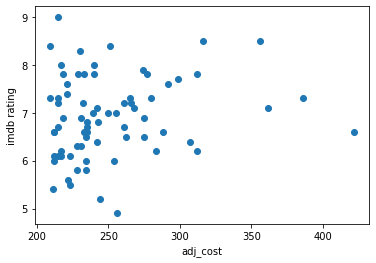

In [25]:
pyplot.scatter(final.adj_cost, final.imdb)
pyplot.xlabel('adj_cost')
pyplot.ylabel('imdb rating')
pyplot.show()

Looking at Rotten Tomatoes, we can also see that lots of movies around the 200-250 million budget mark are getting high critical scores, and increasing the budget is not a guarantee of high scores:

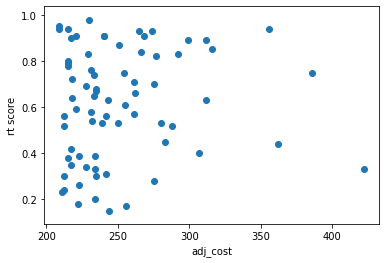

In [26]:
pyplot.scatter(final.adj_cost, final.rt)
pyplot.xlabel('adj_cost')
pyplot.ylabel('rt score')
pyplot.show()

Now we'll want to reflow the data to see how budgets have grown over time:

In [27]:
lineyear = final[['year','adj_cost']]
lineyear

,year,adj_cost
0,2011,422
1,2015,386
2,2007,362
3,2019,356
4,2018,316
...,...,...
67,2014,212
68,2014,212
69,2007,211
70,2008,209


In [28]:
lineyear.dtypes

year        int64
adj_cost    int64
dtype: object

In [29]:
lineyear = lineyear.groupby('year', as_index=False).sum()
lineyear

,year,adj_cost
0,1963,255
1,1978,209
2,1995,283
3,1997,312
4,1998,215
5,1999,256
6,2003,228
7,2004,921
8,2005,497
9,2006,795


We can see below that the amount spent on the highest budgeted movies by Hollywood is increasing over time.

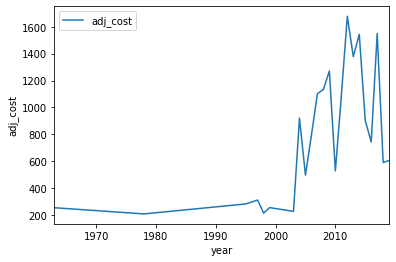

In [30]:
lineyear.plot.line(x = 'year', y = 'adj_cost')
pyplot.xlabel('year')
pyplot.ylabel('adj_cost')
pyplot.show()

Now we'll want to make a table to make the IMDB and Rotten Tomatoes scores on the same scale to make a better apples-to-apples comparison:

In [31]:
normalized_temp = final

In [32]:
normalized_temp['imdb_norm'] = df['imdb']*0.1
normalized_temp

,name,year,adj_cost,nominal_cost,imdb,rt,imdb_norm
0,Pirates of the Caribbean: On Stranger Tides,2011,422,378.5,6.6,0.33,0.66
1,Avengers: Age of Ultron,2015,386,365.0,7.3,0.75,0.73
2,Pirates of the Caribbean: At World's End,2007,362,300.0,7.1,0.44,0.71
3,Avengers: Endgame,2019,356,356.0,8.5,0.94,0.85
4,Avengers: Infinity War,2018,316,316.0,8.5,0.85,0.85
...,...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,212,200.0,6.6,0.52,0.66
68,Exodus: Gods and Kings,2014,212,200.0,6.0,0.30,0.60
69,Evan Almighty,2007,211,175.0,5.4,0.23,0.54
70,WALL-E,2008,209,180.0,8.4,0.95,0.84


In [33]:
'''normalized_temp['adj_cost_grouped'] = [220 if x < 221 
                                       elif x < 241 240
                                       else 0 for x in normalized_temp['adj_cost']]
normalized_temp
'''


def func(row):
    if row['adj_cost'] < 221 :        return 220
    elif row['adj_cost'] <241 :        return 240
    elif row['adj_cost'] <261 :        return 260
    elif row['adj_cost'] <281 :        return 280
    elif row['adj_cost'] <301 :        return 300
    elif row['adj_cost'] <321 :        return 320
    elif row['adj_cost'] <341 :        return 340
    elif row['adj_cost'] <361 :        return 360
    elif row['adj_cost'] <381 :        return 380
    elif row['adj_cost'] <401 :        return 400
    elif row['adj_cost'] <421 :        return 420
    elif row['adj_cost'] <441 :        return 440
    else:
        return 0

normalized_temp['adj_cost_grouped'] = normalized_temp.apply(func, axis=1)
normalized_temp

,name,year,adj_cost,nominal_cost,imdb,rt,imdb_norm,adj_cost_grouped
0,Pirates of the Caribbean: On Stranger Tides,2011,422,378.5,6.6,0.33,0.66,440
1,Avengers: Age of Ultron,2015,386,365.0,7.3,0.75,0.73,400
2,Pirates of the Caribbean: At World's End,2007,362,300.0,7.1,0.44,0.71,380
3,Avengers: Endgame,2019,356,356.0,8.5,0.94,0.85,360
4,Avengers: Infinity War,2018,316,316.0,8.5,0.85,0.85,320
...,...,...,...,...,...,...,...,...
67,The Amazing Spider-Man 2,2014,212,200.0,6.6,0.52,0.66,220
68,Exodus: Gods and Kings,2014,212,200.0,6.0,0.30,0.60,220
69,Evan Almighty,2007,211,175.0,5.4,0.23,0.54,220
70,WALL-E,2008,209,180.0,8.4,0.95,0.84,220


In [34]:
normalized_temp2 = normalized_temp[['adj_cost_grouped','imdb_norm','rt']]
normalized_temp2

,adj_cost_grouped,imdb_norm,rt
0,440,0.66,0.33
1,400,0.73,0.75
2,380,0.71,0.44
3,360,0.85,0.94
4,320,0.85,0.85
...,...,...,...
67,220,0.66,0.52
68,220,0.60,0.30
69,220,0.54,0.23
70,220,0.84,0.95


Here is a table with the ratings averaged for each budget category (in 20 million increments):

In [35]:
normalized_temp3 = normalized_temp2.groupby('adj_cost_grouped', as_index=False).mean()
normalized_temp3

,adj_cost_grouped,imdb_norm,rt
0,220,0.692353,0.615294
1,240,0.680000,0.580870
2,260,0.653333,0.508889
3,280,0.712727,0.716364
4,300,0.702500,0.672500
5,320,0.722500,0.692500
6,360,0.850000,0.940000
7,380,0.710000,0.440000
8,400,0.730000,0.750000
9,440,0.660000,0.330000


The chart below shows that the IMDB user score stays in the same range no matter what the average budget is, so it doesn't make sense to increase the budget to get a better user score:

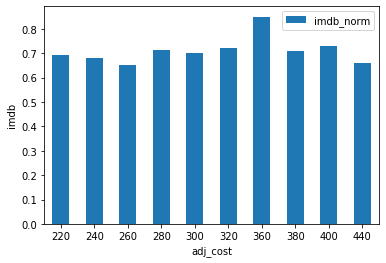

In [36]:
normalized_temp3.plot.bar(x = 'adj_cost_grouped', y = 'imdb_norm', rot=0)
pyplot.xlabel('adj_cost')
pyplot.ylabel('imdb')
pyplot.show()

This chart reflecting average budgets compared to Rotten Tomatoes scores shows that budgets at the higher end may in fact lead to a lower score:

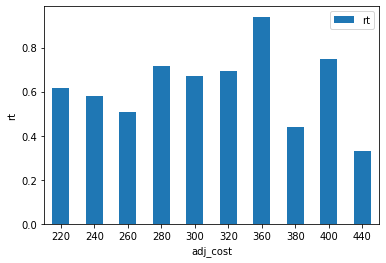

In [37]:
normalized_temp3.plot.bar(x = 'adj_cost_grouped', y = 'rt', rot=0)
pyplot.xlabel('adj_cost')
pyplot.ylabel('rt')
pyplot.show()